In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast 

import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
from pathlib import Path
import tensorflow_io as tfio
import ast
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D


**Build Data Loading Function**

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

**Create Tensorflow Dataset**

In [3]:
SOUND = os.path.join('..', 'Generator', 'audiodata')
SOUND

'..\\Generator_two\\audiodata'

In [4]:
import glob
import re

txtfiles = []
for file in glob.glob(SOUND+"\*.wav"):
    txtfiles.append(file)
txtfiles
sound = sorted(txtfiles, key=lambda s: int(re.search(r'\d+', s).group()))

In [5]:
values = pd.read_csv('../Generator/audiodata/data.csv')['note'].tolist()
osc = list()
for value in values:
    if value == 'a':
        osc.append(tf.one_hot(0,7))
    if value == 'b':
        osc.append(tf.one_hot(1,7))
    if value == 'c':
        osc.append(tf.one_hot(2,7))
    if value == 'd':
        osc.append(tf.one_hot(3,7))
    if value == 'e':
        osc.append(tf.one_hot(4,7))
    if value == 'f':
        osc.append(tf.one_hot(5,7))
    if value == 'g':
        osc.append(tf.one_hot(6,7))


data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(sound), tf.data.Dataset.from_tensor_slices(osc)))

**Build Preprocessing Function to Convert to Spectrogram**

In [6]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:63901] 
    zero_padding = tf.zeros([63901] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

**Create Training and Testing Partitions**

In [7]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [8]:
train = data.take(875)
test = data.skip(875).take(375)

**Build Model**

In [9]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(497, 257,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [11]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 495, 255, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 493, 253, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 246, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 244, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 242, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 121, 61, 64)      0         
 2D)                                                    

**Train**

In [12]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
875/875 [==============================] - 3218s 4s/step - loss: 0.0482 - recall: 0.9781 - precision: 0.9948 - val_loss: 8.5690e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
875/875 [==============================] - 4127s 5s/step - loss: 5.8919e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.4041e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
875/875 [==============================] - 3836s 4s/step - loss: 9.2985e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 8.1051e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
875/875 [==============================] - 3867s 4s/step - loss: 0.1489 - recall: 0.9784 - precision: 0.9885 - val_loss: 2.3607e-04 - val_recall: 1.0000 - val_precision: 1.0000


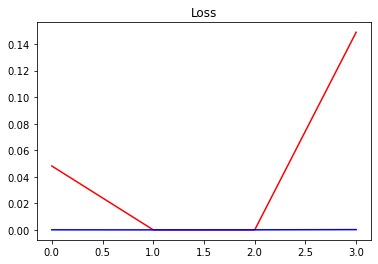

In [13]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [14]:
X_test, y_test = test.as_numpy_iterator().next()
y_test

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
yhat = model.predict(X_test)
#yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.2929894e-16, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.3443627e-25, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [7.0853206e-26, 0.0000000e+00, 8.4164592e-35, 0.0000000e+00,
        0.0000000e+00, 3.4333074e-38, 1.0000000e+00],
       [1.1427805e-31, 0.0000000e+00, 0.0000000e+00, 1.2318790e-25,
        1.0000000e+00, 6.8609669e-18, 0.0000000e+00],
       [8.9324086e-22, 1.4818782e-23, 1.0000000e+00, 5.3800109e-10,
        8.7323116e-23, 2.5818387e-22, 1.1744327e-12],
       [5.7997462e-05, 1.0977056e-07, 1.6137815e-07, 2.4436258e-03,
        9.9160528e-01, 5.8928323e-03, 1.6994683e-08],
       [1.0000000e+00, 0

In [16]:
score = model.evaluate(test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

375/375 [==============================] - 481s 1s/step - loss: 2.3413e-04 - recall: 1.0000 - precision: 1.0000
Test loss: 0.0002341262297704816
Test accuracy: 1.0


In [17]:
model_json = model.to_json()
with open("note.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("note.h5")